In [1]:
import numpy as np
from IPython.display import Image

In [2]:
def init_layers(nn_architecture, seed = 43):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

In [3]:
# activation functions and their derivative
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

$$\boldsymbol{Z}^{[l]} = \boldsymbol{W}^{[l]} \cdot \boldsymbol{A}^{[l-1]} + \boldsymbol{b}^{[l]}$$

$$\boldsymbol{A}^{[l]} = g^{[l]}(\boldsymbol{Z}^{[l]})$$

In [4]:
# forward propagation
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # selection of activation function
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr

def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory

$$\boldsymbol{cost}\space(w,b) = \frac{1}{m}\sum^{i}\boldsymbol{loss}\space(Y^{(i)},\hat{Y}^{(i)})$$
$$\boldsymbol{loss}\space(Y,\hat{Y}) = -[ylog\hat{y}+(1-y)log(1-\hat{y})] $$

In [5]:
def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

## Calculating accuracy

In [6]:
# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [7]:
def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

$$\boldsymbol{dW}^{[l]} = \frac{\partial L }{\partial \boldsymbol{W}^{[l]}} = \frac{1}{m} \boldsymbol{dZ}^{[l]} \boldsymbol{A}^{[l-1] T}$$

$$\boldsymbol{db}^{[l]} = \frac{\partial L }{\partial \boldsymbol{b}^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} \boldsymbol{dZ}^{[l](i)}$$

$$\boldsymbol{dA}^{[l-1]} = \frac{\partial L }{\partial \boldsymbol{A}^{[l-1]}} = \boldsymbol{W}^{[l] T} \boldsymbol{dZ}^{[l]}$$

$$\boldsymbol{dZ}^{[l]} = \boldsymbol{dA}^{[l]} * g'(\boldsymbol{Z}^{[l]})$$



$$\frac{\partial L }{\partial \boldsymbol{\hat{Y}}} = -(\frac{\boldsymbol{Y}}{\boldsymbol{\hat{Y}}}- \frac{1-\boldsymbol{Y}}{1-\boldsymbol{\hat{Y}}})$$

In [8]:
# back propagation
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

In [9]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

In [10]:
def train(X, Y, nn_architecture, epochs, learning_rate, verbose=False, callback=None, seed=43):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, seed)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
#         print('epoch:', i)
        # step forward
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        
        # calculating metrics and saving them in history
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # step backward - calculating gradient
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
    return params_values

In [11]:
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")

from sklearn.metrics import accuracy_score

In [12]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1

X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

print(X.shape)
print(y.shape)

(1000, 2)
(1000,)


In [13]:
# the function making up the graph of a dataset
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()

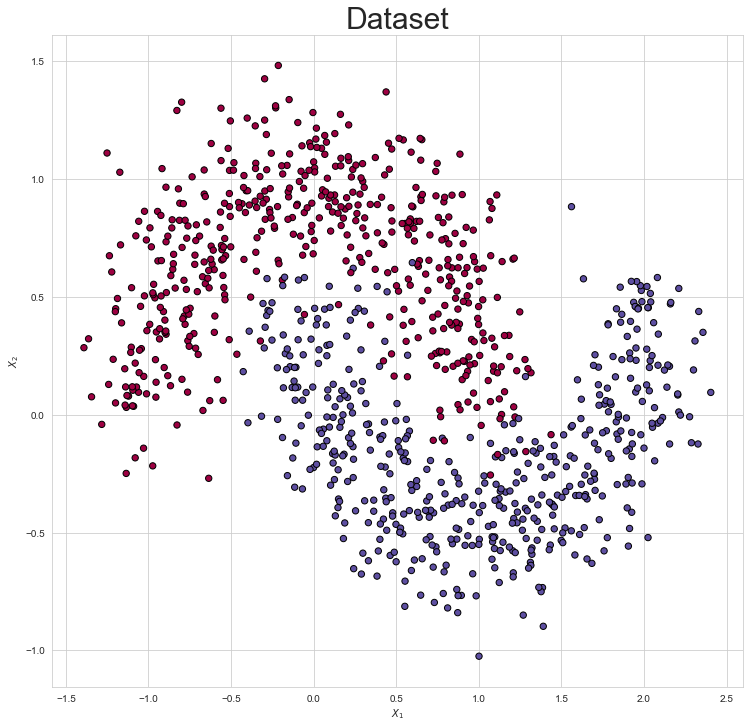

In [14]:
make_plot(X, y, "Dataset")

In [15]:
# Training
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]

params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01,verbose=True)

Iteration: 00000 - cost: 0.69712 - accuracy: 0.49556
Iteration: 00050 - cost: 0.69578 - accuracy: 0.49556
Iteration: 00100 - cost: 0.69482 - accuracy: 0.49556
Iteration: 00150 - cost: 0.69413 - accuracy: 0.49556
Iteration: 00200 - cost: 0.69362 - accuracy: 0.49556
Iteration: 00250 - cost: 0.69322 - accuracy: 0.49556
Iteration: 00300 - cost: 0.69290 - accuracy: 0.49556
Iteration: 00350 - cost: 0.69264 - accuracy: 0.49556
Iteration: 00400 - cost: 0.69241 - accuracy: 0.49556
Iteration: 00450 - cost: 0.69219 - accuracy: 0.49556
Iteration: 00500 - cost: 0.69198 - accuracy: 0.49556
Iteration: 00550 - cost: 0.69177 - accuracy: 0.49556
Iteration: 00600 - cost: 0.69155 - accuracy: 0.49556
Iteration: 00650 - cost: 0.69133 - accuracy: 0.74000
Iteration: 00700 - cost: 0.69111 - accuracy: 0.82444
Iteration: 00750 - cost: 0.69086 - accuracy: 0.83000
Iteration: 00800 - cost: 0.69060 - accuracy: 0.83333
Iteration: 00850 - cost: 0.69032 - accuracy: 0.84000
Iteration: 00900 - cost: 0.69002 - accuracy: 0

Iteration: 07800 - cost: 0.07884 - accuracy: 0.97000
Iteration: 07850 - cost: 0.07861 - accuracy: 0.97000
Iteration: 07900 - cost: 0.07840 - accuracy: 0.97000
Iteration: 07950 - cost: 0.07820 - accuracy: 0.97000
Iteration: 08000 - cost: 0.07800 - accuracy: 0.97000
Iteration: 08050 - cost: 0.07781 - accuracy: 0.97000
Iteration: 08100 - cost: 0.07763 - accuracy: 0.97000
Iteration: 08150 - cost: 0.07745 - accuracy: 0.97000
Iteration: 08200 - cost: 0.07728 - accuracy: 0.97000
Iteration: 08250 - cost: 0.07712 - accuracy: 0.97000
Iteration: 08300 - cost: 0.07696 - accuracy: 0.97000
Iteration: 08350 - cost: 0.07680 - accuracy: 0.97000
Iteration: 08400 - cost: 0.07666 - accuracy: 0.97000
Iteration: 08450 - cost: 0.07651 - accuracy: 0.97000
Iteration: 08500 - cost: 0.07638 - accuracy: 0.97000
Iteration: 08550 - cost: 0.07624 - accuracy: 0.97000
Iteration: 08600 - cost: 0.07612 - accuracy: 0.97111
Iteration: 08650 - cost: 0.07597 - accuracy: 0.97111
Iteration: 08700 - cost: 0.07584 - accuracy: 0

In [16]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [17]:
# Accuracy achieved on the test set
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f} - David".format(acc_test))

Test set accuracy: 0.98 - David


In [18]:
# boundary of the graph
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2
# output directory (the folder must be created on the drive)
OUTPUT_DIR = "./binary_classification_vizualizations/"
os.makedirs(OUTPUT_DIR,exist_ok=True)

grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

In [19]:
def callback_numpy_plot(index, params):
    plot_title = "NumPy Model - It: {:05}".format(index)
    file_name = "numpy_model_{:05}.png".format(index//50)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    prediction_probs, _ = full_forward_propagation(np.transpose(grid_2d), params, NN_ARCHITECTURE)
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    make_plot(X_test, y_test, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs, dark=True)

In [20]:
# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01, False, callback_numpy_plot)


C:\Users\near\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app
C:\Users\near\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app
C:\Users\near\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app
C:\Users\near\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app
C:\Users\near\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app
C:\Users\near\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data rang

In [21]:
import glob
from PIL import Image

# filepaths
fp_in = "binary_classification_vizualizations/*.png"
fp_out = "Training_process.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))[::4]]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=2, loop=0)


![Training Process](Training_process.gif)

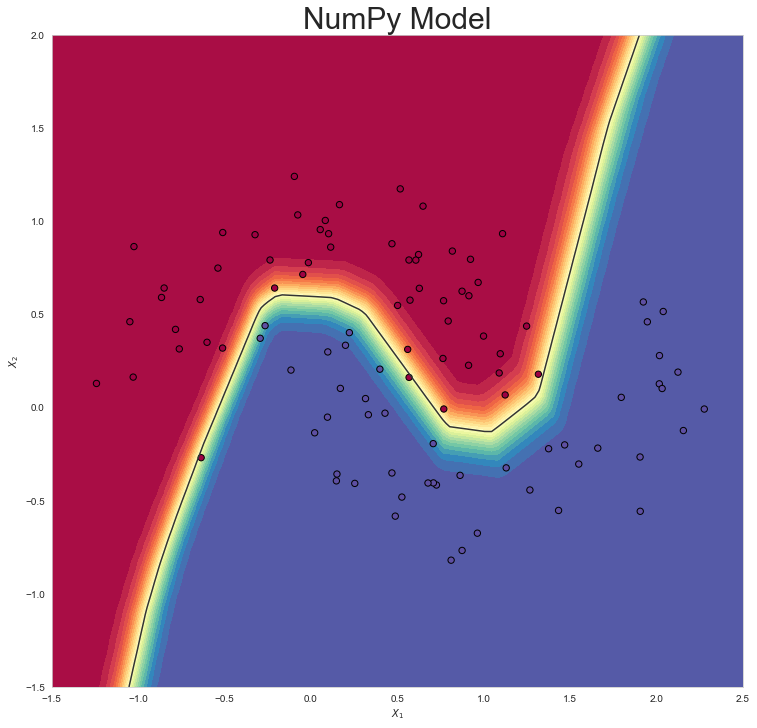

In [22]:
prediction_probs_numpy, _ = full_forward_propagation(np.transpose(grid_2d), params_values, NN_ARCHITECTURE)
prediction_probs_numpy = prediction_probs_numpy.reshape(prediction_probs_numpy.shape[1], 1)
make_plot(X_test, y_test, "NumPy Model", file_name=None, XX=XX, YY=YY, preds=prediction_probs_numpy)
